# Hamper Problem - Solving with a Genetic Algorithm

I was posed an interesting problem by a co-worker (who had come across it somewhere online, I'm not sure of the source). I will outline the specifics of the problem below, but in short it is an optimisation problem. In reality there are better algorithms for solving this specific problem given the information that we have available, but I have been reading about the use of Genetic Algorithms (specifically in hyperparameter optimisation and neuro-evolutionary learning) and figured that this was a good excuse to try writing one myself.

The problem that I'll be solving was proposed as follows:

>A charity purchased some bulk packs, each pack contains 1 or more items. They want to put together as many hampers as they can, with the costs ideally of ¥5000, and they're all as even as possible, so minimise the sum of the absolute difference of the hamper cost to 5000 across all hampers. Design the hampers with no duplicate items.

Please also note that the code in this notebook has been structured to work well in a notebook/blog format, its purpose is to examine/demonstrate how a Genetic Algorithm works and how I applied it to this problem, as opposed to being proper production code.

### Table of Contents

 1. [Problem outline](#problem_outline)
 2. [Data](#data)
 3. [Initial Processing](#initial_processing)
 4. [Building the Genetic Algorithm](#bulding_ga)
 5. [Running the Genetic Algorithm](#running_ga)
 

## 1. Problem outline <a name="problem_outline"></a>

Here is my summary of the problem based on the provided information. There are some points that I would want to discuss/clarify in a real world scenario, but I have made some logical assumptions for these so I can solve the problem.

__Goals:__
* Make multiple hampers from the items in the bulk packs
* Minimise the sum of the absolute difference from ¥5000 for the total cost of the hampers 
* Maximise the number of hampers (I'm assuming the above always takes priority, so this is really a moot point)

__Constraints:__
* Hampers cannot contain duplicate items
* Limited to the number of units specified in the data (i.e. can't exceed this)
* All items must be used (assumed)

__Output:__
* Sum of the absolute difference of hamper cost from ¥5000 across all hampers
* Number of hampers that produces the best result\
* The items in each hamper

All libraries that are used in this notebook are imported below.

In [1]:
import json
from random import randint

from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd
import seaborn as sns

sns.set_style("darkgrid")

## 2. Data <a name="data"></a>
A CSV file has been provided for this problem containing information on the "bulk packs" that the charity has purchased. I have calculated the "total units" and "price per unit" in advance, we'll need to know these to solve the problem. I'll read the data into a pandas dataframe. You can see the last 5 items below (there are 15 in total).

In [2]:
df = pd.read_csv("CharityBulkPurchaseList.csv")
df.tail()

,item,brand,units per pack,price per pack,quantity of packs,total units,price per unit
10,Tea,Superior,5,2720,2,10,544.0
11,Tofu,Gourmet Choice,1,1580,10,10,1580.0
12,Tomato sauce,Best Family,1,190,10,10,190.0
13,UHT milk,Atlantic,6,4560,2,12,760.0
14,Vegetable oil,Crafco,12,10020,1,12,835.0


We'll also need to know the total amount spent on all of these items in the section below so I'll calculate that here.

In [3]:
# Price per pack x quantity of packs gives us the value of all units of that item
# The sum of this gives the total value of all items bought by the charity
total_item_value = ( df["price per pack"] * df["quantity of packs"] ).sum()

print(f"Total value of all items: ¥{total_item_value}")

Total value of all items: ¥126709


## 3. Initial Processing <a name="intial_processing"></a>
We can use the data above to determine the ideal number of hampers and the best possible sum absolute cost diff, without working out what is actually in the hampers. This will help narrow our search space and help us evaluate how the algorithm is performing.

### Estimating the ideal number of hampers

If we simply treat this as an exercise of puting money in the hampers we can easily determine the ideal number of hampers. We want each hamper to be worth ¥5000 (or as close to this as possible), therefore we can divide the total cost of all items by 5000 to work out how many hampers we can make that are worth ¥5000.

In [4]:
target_hamper_value = 5000

# We can make n_hampers_unrounded hampers if all hampers are the target value
n_hampers_unrounded = total_item_value / target_hamper_value
# Round to nearest whole number since we can't make a fraction of a hamper
n_hampers = round(n_hampers_unrounded)

print(f"Ideal number of hampers = {n_hampers_unrounded} = {n_hampers} hampers")

Ideal number of hampers = 25.3418 = 25 hampers


### Calculating the lowest possible difference

Note that we had to round the number above to get to a whole number (since we can't put an item in .3418 of a hamper). This means that we will have some money/items left over after getting all our hampers to be worth ¥5000. Since we need to use all items we'll need to distribute these between the hampers. The money that is left over is the best possible sum of the absolute difference of hamper cost from ¥5000 across all hampers.

In [5]:
rounding_amount = n_hampers_unrounded - n_hampers
target_cost_diff = abs(round(rounding_amount*5000))

print(f"Ideal sum absolute cost diff = ¥{target_cost_diff}")

Ideal sum absolute cost diff = ¥1709


This "ideal" value may not necessarily be achievable depending on the exact prices an amounts of items but it gives us something to benchmark against and a point to stop at if necessary.

### Sum absolute cost diff vs Number of hampers

Below I've calculated the sum of abs diff from 5000 across all hampers for a number of different number of hampers. This uses the equation below, which is more or less the same as what we did above.

$$ \Delta = | \sum_{i=1}^{n_{i}}p_{item} -  n_{hampers} \times 5000 | $$

This plot shows that 25 hampers is by far the best number of hampers.

Text(0, 0.5, 'Sum of abs diff from 5000')

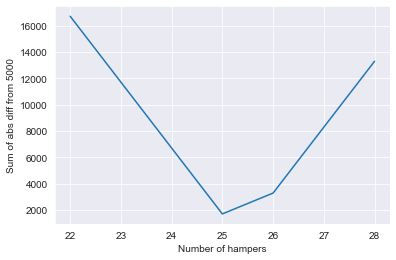

In [11]:
%matplotlib inline

hampers = np.array([22, 23, 24, 25, 26, 27, 28])
cost_diff = np.abs(total_item_value - hampers * 5000)

fig, ax = plt.subplots()
ax.plot(hampers, cost_diff)
ax.set_xlabel("Number of hampers")
ax.set_ylabel("Sum of abs diff from 5000")

## 4. Building the Genetic Algorithm <a name="building_ga"></a>

A Genetic Algorithm is a type of evolutionary algorithm that was inspired by natural selection. This algorithm will look to evolve an initial set of possible solutions (in this case randomised) to an optimised solution. It does this by "breeding" and "mutating" the best solutions (refered to as chromosomes) over multiple generations. 

The Genetic Algorithm used for this problem will take the following steps (This is visualised in the diagram below):
* __Step 1 - Initialise population__: This is done at the start of the process and provides an initial population of solutions for the algorithm to work with. In this case it will be a set of psuedo-random solutions that fit the constraits of the problem (e.g. no duplicate items in a hamper).
* __Step 2 - Fitness calculation__: The fitness calculation provides a metric to score which chromosomes are performing the best. In this case it will be the sum of the absolute difference from 5000 across all hampers.
* __Step 3 - Check if it should terminate__: Determine if the target fitness has been met or some other limit reached (e.g. total number of generations or no improvement in n generations).
* __Step 4 - Selection__: Select the fittest solutions to make the next generation
* __Step 5 - Crossover__: Combine fittest "parent" solutions to create new solutions (parents will also be in the next generation)
* __Step 6 - Mutation__: Randomly change parts of the solutions for some of the new population.
* __Repeat from Step 2__ until a termination criterum is met

<img src="./GAProcessDiagram.png" width=300/>

Note: Genetic Algorithms will find __an__ optimised solution not always the most optimal solution. They can potentially give different answers each time they are run. There are other approaches better suited to finding the most optimal solution (and more efficient approaches), but I wanted to play around with this kind of algorithm.

### The Chromosome

In [7]:
def chromosome_to_hampers(chromosome: list, num_hampers: int) -> list:
    # Item in hamper shouldn't be greater than the number of hampers
    if any(hamper > num_hampers - 1 for pack in chromosome for hamper in pack):
        msg = f"Hamper in chromosome is greater than num_hampers {num_hampers}"
        raise Exception(msg)

    # Empty hampers to add items into
    hampers = [[] for _ in range(num_hampers)]

    # Iterate through chromosome to put items into their hampers
    for i, pack in enumerate(chromosome):
        for assigned_hamper in pack:
            hampers[assigned_hamper].append(i)

    return hampers


hampers = chromosome_to_hampers([[0,1,2],[3,4,1],[0,4,3]], 5)
print(hampers)

[[0, 1, 1, 0]]

[[0, 2], [0, 1], [0], [1, 2], [1, 2]]


[[0, 1, 1, 0]]

###  Initialisation

The genetic algorithm will need an inital set of solutions to optimised. These will be created by randomly assigning items to hampers. It will be important to do this in a way that ensure the hampers that are created are valid (i.e. no duplicate items) otherwise there is the potential for many or all of the random solutions to be invalid which can significantly slow down the optimisation.

This is done by keeping track of the hampers that an item can be added to (i.e. hampers that don't already contain that item).

In [8]:
def make_random_solution(num_hampers: int, item_lookup: dict) -> list:
    solutions = []
    for item in item_lookup:
        num_units = item_lookup[item]["total units"]
        pack = randomly_distribute_pack(num_units, num_hampers)
        solutions.append(pack)

    return solutions


def randomly_distribute_pack(num_units: int, num_hampers: int) -> list:
    # Will track which hampers an item can be assigned to.
    hamper_options = list(range(1, num_hampers + 1))

    # Go through each unit of an item and distribute it to a hamper
    item_assignments = []
    for i in range(num_units):
        # Randomly select a hamper from the available hampers to assign the item to
        available_hampers = len(hamper_options) - 1
        hamper_idx = randint(0, available_hampers)

        # Remove the hamper as it is no longer available
        hamper = hamper_options.pop(hamper_idx)

        item_assignments.append(hamper)

    return item_assignments

### Fitness

Once we have an initial population to work with, we need a way of assessing the fitness of a given solution. 
We then need to assign a score based on the sum absolute difference of the hampers from the target value of 5000. To do this will we calculate the ideal sum value of the hampers $(5000 \times n_{hampers})$. Our fitness score will be based on how far from this we are. So we will be aiming to maximise the equation below.

$$ 5000 \times n_{hampers} - \sum_{i=1}^{n_{hampers}} | 5000 - \sum_{i=1}^{n_{i}} price_i | $$

Solutions that are invalid are given a fitness of 0.

In [9]:
def calc_fitness(
    chromosome: list,
    item_lookup: dict,
    num_hampers: int,
    target_hamper_value: float
) -> float:
    # Make hampers from chromosome so we can calculate their value
    hampers = chromosome_to_hampers(chromosome, num_hampers)

    # Hamper value for all hampers in solution so we can find the sum of the absolute
    hamper_values = [calc_hamper_value(hamper, item_lookup) for hamper in hampers]

    # difference from 5000 across all hampers
    diffs = [abs(value - target_hamper_value) for value in hamper_values]

    return sum(diffs)

### Selection

Now we have a function for determining fitness of a solution we now need to write a function that selects solutions to use a parents for the next generation.

In [10]:
def selection(fitness: list, num_parents: int, population: list) -> list:
    """Select the fittest solutions to use as parents for the next generation."""
    # Predefine array of indivduals that will be parents for the next generation
    parents = np.empty((num_parents, population.shape[1]))
    for i in range(num_parents):
        # Finding the fittest solution
        max_fitness_idx = np.where(fitness == np.max(fitness))
        parents[i,:] = population[max_fitness_idx[0][0], :]
        # Ensuring this solution is not selected next time
        fitness[max_fitness_idx[0][0]] = -999999
    return parents

### Crossover

### Mutation

### Termination

## 5. Running the Genetic Algorithm <a name="running_ga"></a>